<h1><center>Physique numérique (PHY-3500) - TP4</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [1]:
from typing import Optional

import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Atténuation des rayons X

1) *Supposons, pour simplifier, que le corps humain est fait d’eau pure. Grâce à la base de données XCOM du NIST, trouvez le $\mu$ de l’eau pour des photons de 60 keV, à une masse volumique de 1.0 g/cm³. Quelle fraction du signal subsiste après avoir traversé 5 cm d’eau ; 20 cm d’eau ?*

Pour commencer, il faut calculer le coefficient d'atténuation $\mu$ de l'eau pour des photons de 60 keV et ensuite déterminer la fraction du signal qui subsiste après avoir traversé 5 cm et 20 cm d'eau. Le coefficient $\mu$ pour l'eau à 60 keV est obtenu en utilisant la base de donnée du NIST. [1] Le graphique ci-dessous montre l'attenuation totale de l'eau pour des photons dont l'énergie est comprise entre 0,1 keV et 100 MeV. Ce graphique inclu toutes les formes d'atténuation des rayons X, cohérente (diffusion de Rayleigh) et incohérente (effet Compton), ainsi que l'absorption photoélectrique, ce qui donne une vue d'ensemble de l'atténuation totale que subirait le rayon X dans l'eau à différentes énergies. Ensuite, en utilisant la loi de Beer-Lambert, l'intensité $I$ des rayons X après avoir traversé un matériau est donnée par :
$$I = I_0e^{-\rho\mu x} \ ,$$

où $I_0$ est l'intensité initiale, $\mu$ est le coefficient d'atténuation linéaire, en cm²/g, $\rho$ est la densité du matériau, en g/cm² et $x$ est l'épaisseur du matériau en cm. Comme l'eau a une densité de 1 g/cm², l'équation devient :
$$I = I_0e^{-\mu x} \ .$$

La fraction du signal restant est donc donnée par :
$$F_I = \frac{I}{I_0} = e^{-\mu x} \ .$$

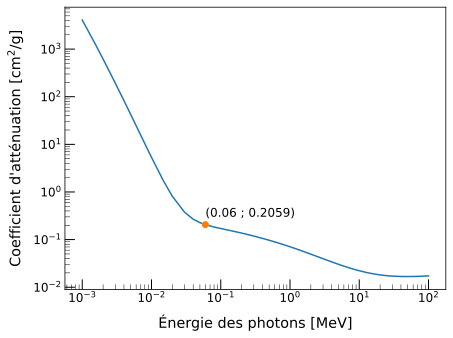

In [2]:
# Extraction des données d'atténuation
att = np.loadtxt("data/attenuation.txt")
a_60 = np.where(att[:, 0] == 0.06)
E_mu, mu = att[a_60].ravel()

plt.plot(att[:, 0], att[:, 1])
plt.plot(att[a_60, 0], mu, "o", c="#FF7C00")
plt.text(
    E_mu,
    mu * 1.3,
    f"({E_mu} ; {mu})",
    verticalalignment="bottom",
    fontsize=12,
)
plt.xlabel("Énergie des photons [MeV]")
plt.ylabel("Coefficient d'atténuation [$\\rm cm^2/g$]")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [3]:
x = np.asarray((5, 20)) # épaisseurs en cm
frac = np.exp(-mu * x)

print(f"Fraction d'intensité restante après 5 cm d'eau : {frac[0]}")
print(f"Fraction d'intensité restante après 20 cm d'eau : {frac[1]}")

Fraction d'intensité restante après 5 cm d'eau : 0.35718550868274057
Fraction d'intensité restante après 20 cm d'eau : 0.016277035981532836


# Reconstruction par rétroprojection

2) En utilisant le code fourni (ou pas), créer une rétroprojection simple, aussi appelée laminogramme, des données de projection fournies. Notez qu’une approche par slicing pourrait accélérer votre algorithme. Votre code utilisera la méthode du plus proche voisin pour déterminer la valeur de projection à utiliser (le rayon passant par la source et le voxel d’intérêt n’aboutit pas nécessairement au centre des pixels du détecteur). Une fois que vous aurez accès au fantôme numérique, comparez-le à la reconstruction. Qualitativement, quelles différences observez-vous entre l’image reconstruite et l’image de référence (fantôme) ?


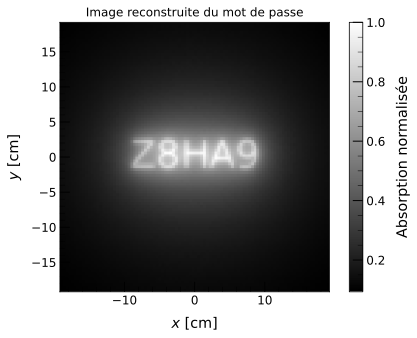

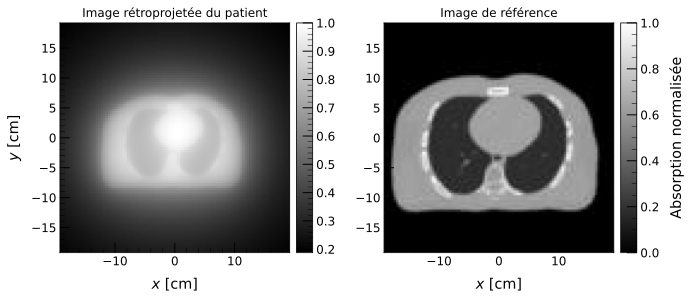

In [4]:
def retroprojection(
    sinogram: NDArray,
    angles: NDArray,
    size: Optional[NDArray] = None,
) -> NDArray:
    """Rétroprojection simple avec l'interpolation du plus proche voisin.

    Paramètres
    ----------
        sinogram
            Données du sinogramme (2D) où chaque ligne correspond à une
            projection à un angle spécifique.
        angles
            Angles en degré auxquels les projections ont été prises.
        size
            Taille de l'image de sortie, spécifiant la résolution de
            l'image reconstruite.

    Retourne
    --------
        img
            Image reconstruite par rétroprojection à partir des projections
            dans le sinogramme.

    """
    # Résolution complète par défaut
    sin_y, sin_x = sinogram.shape
    if size is None:
        size = np.asarray((sin_x, sin_x), dtype=np.uint16)

    # Création d'une grille pour l'image de sortie
    img = np.zeros(size, dtype=np.float32)
    x = np.linspace(1, -1, size[0])
    y = np.linspace(-1, 1, size[1])
    grid_x, grid_y = np.meshgrid(x, y)

    # Calcul des lignes de projection aux angles donnés
    angles = np.radians(angles[:, None, None])
    t = grid_x * np.cos(angles) + grid_y * np.sin(angles)

    # Mise à l'échelle de 't' pour correspondre aux indices du sinogramme
    ts = np.interp(t, (-1, 1), (0, sin_x - 1))

    # Extraction des plus proches indices de ts dans les limites de l'image
    idx = np.round(ts).astype(np.uint16)
    idx = np.clip(idx, 0, sin_x - 1)

    # Sommation vectorisée des valeurs projetées sur l'image
    batch_idx = np.arange(sin_y, dtype=np.uint16)[:, None, None]
    vals = sinogram[batch_idx, idx]
    img = vals.sum(axis=0)

    # Normalisation de l'image
    img /= img.max()
    return img


# Chargement des angles et des données du sinogramme
psw = np.loadtxt("data/sinogram-password.txt")
patient = np.loadtxt("data/sinogram-patient.txt")
angles = np.loadtxt("data/angles.txt", dtype=np.float16)

pix_size = 0.4
size = np.asarray((96, 96), dtype=np.uint8)
scale_x, scale_y = size * pix_size / 2
ax_lims = np.asarray((-scale_x, scale_x, -scale_y, scale_y))

# Réalisation de la rétroprojection
img_psw = retroprojection(psw, angles, size)
img_patient = retroprojection(patient, angles, size)
img_ref = plt.imread("data/phantom-thorax-096-smooth.png")

# Affichage de l'image reconstruite du mot de passe
kwargs = {"cmap": "gray", "extent": ax_lims}
plt.imshow(img_psw, **kwargs)
plt.title("Image reconstruite du mot de passe")
plt.xlabel("$x$ [cm]")
plt.ylabel("$y$ [cm]")
plt.colorbar(label="Absorption normalisée")
plt.show()

# Affichage des images reconstruites
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_ylabel("$y$ [cm]")
axs[0].set_title("Image rétroprojetée du patient")
axs[1].set_title("Image de référence")

# Ajustement de la taille des colorbar
imgs = img_patient, img_ref
for n, ax in enumerate(axs.flat):
    ax.set_xlabel("$x$ [cm]")
    ax_div = make_axes_locatable(ax)
    cax = ax_div.append_axes("right", size="7%", pad="3%")
    im = ax.imshow(imgs[n], **kwargs)
    cbar = fig.colorbar(im, cax=cax)

cbar.set_label("Absorption normalisée")
plt.tight_layout(pad=2)
plt.show()

L'image reconstruite par rétroprojection simple et l'image de référence présentent plusieurs différences qualitatives notables. L'image rétroprojetée (à gauche) apparaît beaucoup plus floue que l'image de référence (à droite). La rétroprojection simple a tendance à produire un flou, particulièrement visible autour des bords des structures, car elle superpose toutes les projections sans considération des contributions fréquentielles, ce qui mène à une perte de résolution spatiale. Le contraste dans l'image de rétroprojection est moindre par rapport à l'image de référence. Les zones d'intensité élevée dans l'image de référence sont plus diffuses dans l'image rétroprojetée. Les bords des structures nets et précis dans l'image de référence sont irréguliers et moins définis dans l'image rétroprojetée, ce qui rend difficile la distinction entre des structures à différents niveaux de transmission.

# Rétroprojection filtrée

3) *En utilisant la librairie ``numpy.fft``, implémentez le filtre passe-haut proposé pour filtrer le sinogramme une projection à la fois. Affichez et sauvegardez l’image du sinogramme filtré. Qualitativement, quelles sont les principales différences entre le sinogramme fourni et filtré ?*

Le filtre de rampe compense la perte des hautes fréquences due à l'intégration des rayons X dans le processus de mesure de l'atténuation, ce qui résulte en général dans une image plus nette et plus précise. En termes mathématiques, le filtre de rampe multiplie la transformée de Fourier de chaque projection par la fréquence absolue.

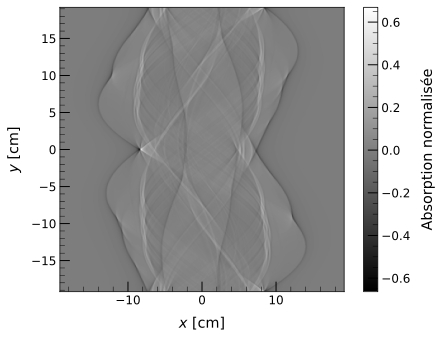

In [5]:
def ramp_filter(sinogram: NDArray, spacing: int | float = 1) -> NDArray:
    """Applique un filtre de rampe passe-haut à la FFT du sinogramme.

    Parameters
    ----------
        sinogram
            Données du sinogramme (2D) où chaque ligne correspond à une
            projection à un angle spécifique.
        spacing
            Espacement des pixels, en cm, dans le sinogramme.

    Retourne
    --------
        filt_sin
            Sinogramme après l'application du filtre.

    """
    # Facteur d'échelle de fréquence dans le domaine de Fourier
    freqs = np.fft.fftfreq(sinogram.shape[1], d=spacing)

    # Construction du filtre en rampe dans le domaine de Fourier
    ramp = np.abs(freqs)

    # Appliquer le filtre en rampe pour chaque projection
    filt_proj = np.fft.fft(sinogram) * ramp
    filt_sin = np.fft.ifft(filt_proj).real
    return filt_sin


# Filtrage des rétroprojections
patient_filt = ramp_filter(patient, pix_size)

plt.imshow(patient_filt, **kwargs)
plt.xlabel("$x$ [cm]")
plt.ylabel("$y$ [cm]")
plt.colorbar(label="Absorption normalisée")

# Sauvegarde de l'image avec les paramètres du fichier 'LabReport.mplstyle'
# plt.savefig("filtered-sinogram")

# Affichage du sinogramme filtrée
plt.show()

4) Ayant en main le sinogramme filtré, effectuez une rétroprojection filtrée, en récupérant
idéalement le code précédent du laminogramme. Comparez l’image obtenue avec le fantôme. Quelles différences observez-vous ? Ou sont situées les erreurs et que diriez-vous de la fréquence spatiale des erreurs ?


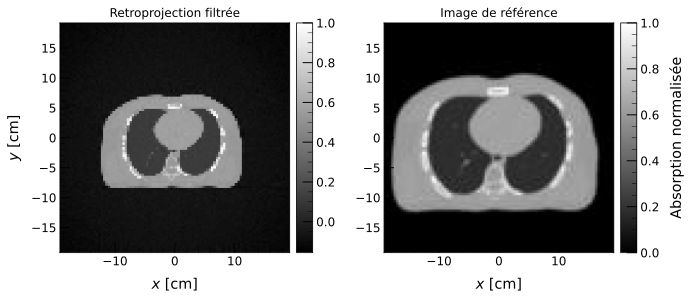

In [6]:
img_patient_filt = retroprojection(patient_filt, angles, size)

# Affichage des images reconstruites
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_ylabel("$y$ [cm]")
axs[0].set_title("Retroprojection filtrée")
axs[1].set_title("Image de référence")

# Ajustement de la taille des colorbar
imgs = img_patient_filt, img_ref
for n, ax in enumerate(axs.flat):
    ax.set_xlabel("$x$ [cm]")
    ax_div = make_axes_locatable(ax)
    cax = ax_div.append_axes("right", size="7%", pad="3%")
    im = ax.imshow(imgs[n], **kwargs)
    cbar = fig.colorbar(im, cax=cax)


cbar.set_label("Absorption normalisée")
plt.tight_layout(pad=2)
plt.show()

# Reconstruction via le théorème de la tranche de Fourier

5) Ecrivez une nouvelle fonction de reconstruction ``reconFourierSlice()`` qui effectue la reconstruction via le théorème de la tranche de Fourier. Il faut effecteur la TF 1D de chaque projection du sinogramme et stocker le nouveau sinogramme transformé. Par échantillonnage du sinogramme, remplissez l’espace de Fourier 2D de l’image à reconstruire. Vous pouvez choisir l’angle approprié par la méthode du plus proche voisin et la position sur le détecteur par interpolation linéaire. Trouvez l’image par $\rm TF^{−1}$ 2D et commentez les résultats. Indice : considérez toutes les données comme des nombres complexes avec l’initialisation suivante ``mymatrix = numpy.zeros((a, b), complex)``, puis prenez la partie réelle de l’image finale.

In [7]:
def reconFourierSlice(
    sinogram: NDArray,
    angles: NDArray,
    size: Optional[NDArray] = None,
    spacing: int | float = 1,
) -> NDArray:
    """Reconstruction d'image via le théorème de la tranche de Fourier.

    Paramètres
    ----------
        sinogram
            Données du sinogramme (2D) où chaque ligne correspond à une
            projection à un angle spécifique.
        angles
            Angles en degré auxquels les projections ont été prises.
        size
            Taille de l'image de sortie, spécifiant la résolution de
            l'image reconstruite.
        spacing
            Espacement des pixels, en cm, dans le sinogramme.

    Retourne
    --------
        img
            Image reconstruite par TF-1 à partir des projections
            du sinogramme dans l'espace de Fourier 2D.

    """
    # Résolution complète par défaut
    sin_y, sin_x = sinogram.shape
    if size is None:
        size = np.asarray((sin_x, sin_x), dtype=np.uint16)

    # Création d'une grille pour l'image de sortie
    F = np.zeros(size, dtype=np.complex64)

    # Initialisation de l'espace de Fourier 2D
    # freqs = np.fft.fftfreq(sinogram.shape[1], d=0.4)
    freq_x = np.fft.fftfreq(sin_x, d=spacing)
    freq_y = np.fft.fftfreq(sin_y, d=spacing)
    grid_x, grid_y = np.meshgrid(freq_x, freq_y)

    # Calcul de la TF 1D des projections
    proj_fft = np.fft.fft(sinogram)

    # Création d'une grille pour l'image de sortie
    # img = np.zeros(size, dtype=complex)
    # x = np.linspace(-1, 1, size[0])
    # y = np.linspace(-1, 1, size[1])
    # grid_x, grid_y = np.meshgrid(x, y)

    # Calcul des projections
    angles = np.radians(angles[:, None, None])
    t = grid_x * np.cos(angles) + grid_y * np.sin(angles)

    # Mise à l'échelle de 't' pour mapper aux indices du sinogramme
    sin_y, sin_x = proj_fft.shape
    ts = np.interp(t, (-1, 1), (0, sin_x - 1))

    # Extraction des plus proches indices de ts dans les limites de l'image
    idx = np.round(ts).astype(np.uint16)
    idx = np.clip(idx, 0, sin_x - 1)

    # Sommation vectorisée des valeurs projetées sur l'image
    batch_idx = np.arange(sin_y)[:, None, None]
    vals = proj_fft[batch_idx, idx]

    F = vals.sum(axis=0)
    img = np.fft.ifft(F).real

    # Normalisation de l'image
    img /= img.max()
    return img


size = np.asarray((96, 96))

# Reconstruct the image
# image = reconFourierSlice(patient, angles, size)
# image = retroprojection_fourier(patient, angles, size)

# Display the image
# plt.imshow(image, **kwargs)
# plt.xlabel("$x$ [cm]")
# plt.ylabel("$y$ [cm]")
# plt.colorbar()
# plt.show()

# Références

[1] Martin J. Berger *et al*. XCOM: Photon Cross Sections Database (Version 3.1). National Institute of Standards and Technology (NIST), 2010. URL : https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html. Page consultée le 12 avril 2024.